In [148]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder   
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline 
# from sklearn.svm import SVC

In [149]:
# Read the data from the CSV file
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [150]:
print(df.shape)
df.info()

(119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  mea

In [151]:
# Checking datatypes
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [152]:
df.columns.tolist()

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

## Preprocessing

In [153]:
# Selecting columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

children         4
country        488
agent        16340
company     112593
dtype: int64

In [154]:
# Calculate the percentage of missing values per column
missing_values = missing_values * 100 / len(df)
missing_values

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

In [155]:
# Drop the columns agent , company
df.drop(['agent','company'], axis=1, inplace=True)

In [156]:
df.isnull().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car

In [157]:
# Count the no. of unique values in each column
unique_values = df.nunique()
unique_values

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
days_in_waiting_list               128
customer_type                        4
adr                      

In [158]:
# Drop the rows with missing values in the column 'country'
df = df.dropna(subset=['country'])

In [159]:
# Replace missing values in the column 'children' with 0
df['children'] = df['children'].fillna(0)

In [160]:
# Drop the rows if the values = 0 in the column 'adult' and 'children' and 'babies'
df = df.drop(df[(df.adults+df.children+df.babies)==0].index)

In [161]:
# Count the columns with missing values
if df.isnull().sum().sum() == 0:
    print('No missing values')

No missing values


In [162]:
df.shape

(118732, 30)

In [163]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_status_date']

0        2015-07-01
1        2015-07-01
2        2015-07-02
3        2015-07-02
4        2015-07-03
            ...    
119385   2017-09-06
119386   2017-09-07
119387   2017-09-07
119388   2017-09-07
119389   2017-09-07
Name: reservation_status_date, Length: 118732, dtype: datetime64[ns]

In [164]:
# Merge the columns 'arrival_date_year', 'arrival_date_month' and 'arrival_date_day_of_month' into a single column 'arrival_date'
df['arrival_date'] = pd.to_datetime(df.arrival_date_year.astype(str) + '-' + df.arrival_date_month.astype(str) + '-' + df.arrival_date_day_of_month.astype(str))
df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis=1, inplace=True)
df

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,27,0,0,2,0.0,0,BB,...,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,27,0,0,2,0.0,0,BB,...,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,27,0,1,1,0.0,0,BB,...,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,27,0,1,1,0.0,0,BB,...,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,27,0,2,2,0.0,0,BB,...,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,35,2,5,2,0.0,0,BB,...,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,0,102,35,2,5,3,0.0,0,BB,...,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,0,34,35,2,5,2,0.0,0,BB,...,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,0,109,35,2,5,2,0.0,0,BB,...,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


In [165]:
# Move the column 'arrival_date' to the 4th position
cols = df.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[3:-1]
df = df[cols]
df


,hotel,is_canceled,lead_time,arrival_date,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015-07-01,27,0,0,2,0.0,0,...,C,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015-07-01,27,0,0,2,0.0,0,...,C,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015-07-01,27,0,1,1,0.0,0,...,C,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015-07-01,27,0,1,1,0.0,0,...,A,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015-07-01,27,0,2,2,0.0,0,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017-08-30,35,2,5,2,0.0,0,...,A,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017-08-31,35,2,5,3,0.0,0,...,E,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017-08-31,35,2,5,2,0.0,0,...,D,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017-08-31,35,2,5,2,0.0,0,...,A,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [166]:
# Merge the rows of 'required_car_parking_spaces' into two categories: 0 and 1
print(df['required_car_parking_spaces'].value_counts())
df.loc[df['required_car_parking_spaces'] > 0, 'required_car_parking_spaces'] = 1
df['required_car_parking_spaces'].value_counts()

required_car_parking_spaces
0    111429
1      7270
2        28
3         3
8         2
Name: count, dtype: int64


required_car_parking_spaces
0    111429
1      7303
Name: count, dtype: int64

In [167]:
df.shape

(118732, 28)

In [168]:
# Save the cleaned data frame to a CSV file
# df.to_csv('hotel_bookings_cleaned.csv', index=False)

## Encoding the categorical columns and discretizing the numerical columns

In [169]:
# Split the data into two data frames: one for the numerical columns and one for the categorical columns
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_cat = df.select_dtypes(include = ['object'])

In [170]:
df.shape

(118732, 28)

In [171]:
df_num.shape, df_cat.shape

((118732, 16), (118732, 10))

In [172]:
# Show the numerical columns
numerical_features = df_num.columns.tolist()

# Remove the target column 'is_canceled' from the list of numerical columns
numerical_features.remove('is_canceled')
numerical_features

['lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [173]:
# Show the categorical columns
categorical_features = df_cat.columns.tolist()
categorical_features

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

In [174]:
# Show the unique values in each categorical column
df_cat.nunique()

hotel                     2
meal                      5
country                 177
market_segment            8
distribution_channel      5
reserved_room_type        9
assigned_room_type       11
deposit_type              3
customer_type             4
reservation_status        3
dtype: int64

In [175]:
# Sort the indices of df_num to start from 0 to n
df_num = df_num.reset_index(drop=True)
df_num

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,27,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,0,737,27,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,0,7,27,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,0,13,27,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,0,14,27,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118727,0,23,35,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
118728,0,102,35,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
118729,0,34,35,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
118730,0,109,35,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


In [185]:
# Define the pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

In [186]:
# Define the pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [196]:

# # drop children                          0.0
# babies                            0.0
# is_repeated_guest                 0.0
# previous_cancellations            0.0
# previous_bookings_not_canceled    0.0
# days_in_waiting_list              0.0
# required_car_parking_spaces       0.0
numerical_features_zero_mean = ['children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'required_car_parking_spaces']

# Remove the columns with zero mean from the list of numerical columns
numerical_features_no_zero_mean = list(set(numerical_features) - set(numerical_features_zero_mean))

# Column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('label', 'passthrough', ['is_canceled']),
        ('num', numerical_pipeline, numerical_features_no_zero_mean),
        ('cat', categorical_pipeline, categorical_features),
    ],
    remainder='drop' 
)

In [197]:
# Fit and transform the data
transformed_data = preprocessor.fit_transform(df)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

In [199]:
# Check na values in the numerical_features_zero_mean
df[numerical_features_zero_mean].shape

(118732, 7)

In [201]:
# Convert the transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=['is_canceled'] + numerical_features_no_zero_mean + categorical_features , index=df.index)
transformed_df.head()

# Merge the columns with zero mean back to the transformed data with index
transformed_df = pd.concat([transformed_df, df[numerical_features_zero_mean]], axis=1)
    
transformed_df.head()

,is_canceled,booking_changes,lead_time,stays_in_week_nights,adr,arrival_date_week_number,stays_in_weekend_nights,total_of_special_requests,adults,hotel,...,deposit_type,customer_type,reservation_status,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,days_in_waiting_list,required_car_parking_spaces
0,0.0,1.0,9.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,...,0.0,2.0,1.0,0.0,0,0,0,0,0,0
1,0.0,1.0,9.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,...,0.0,2.0,1.0,0.0,0,0,0,0,0,0
2,0.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,2.0,1.0,0.0,0,0,0,0,0,0
3,0.0,0.0,2.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,2.0,1.0,0.0,0,0,0,0,0,0
4,0.0,0.0,2.0,2.0,5.0,4.0,0.0,1.0,2.0,1.0,...,0.0,2.0,1.0,0.0,0,0,0,0,0,0


In [202]:
transformed_df.isna().sum()

is_canceled                       0
booking_changes                   0
lead_time                         0
stays_in_week_nights              0
adr                               0
arrival_date_week_number          0
stays_in_weekend_nights           0
total_of_special_requests         0
adults                            0
hotel                             0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
reserved_room_type                0
assigned_room_type                0
deposit_type                      0
customer_type                     0
reservation_status                0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
days_in_waiting_list              0
required_car_parking_spaces       0
dtype: int64

In [203]:
# Get mean of each column
mean = transformed_df.mean()
mean
# Get columns with mean = 0.0
zero_mean = mean[mean == 0.0]
zero_mean

Series([], dtype: float64)

In [102]:
# Save the transformed data frame to a CSV file
transformed_df.to_csv('hotel_bookings_transformed.csv', index=False)

## Splitting the data into x_data and y_data

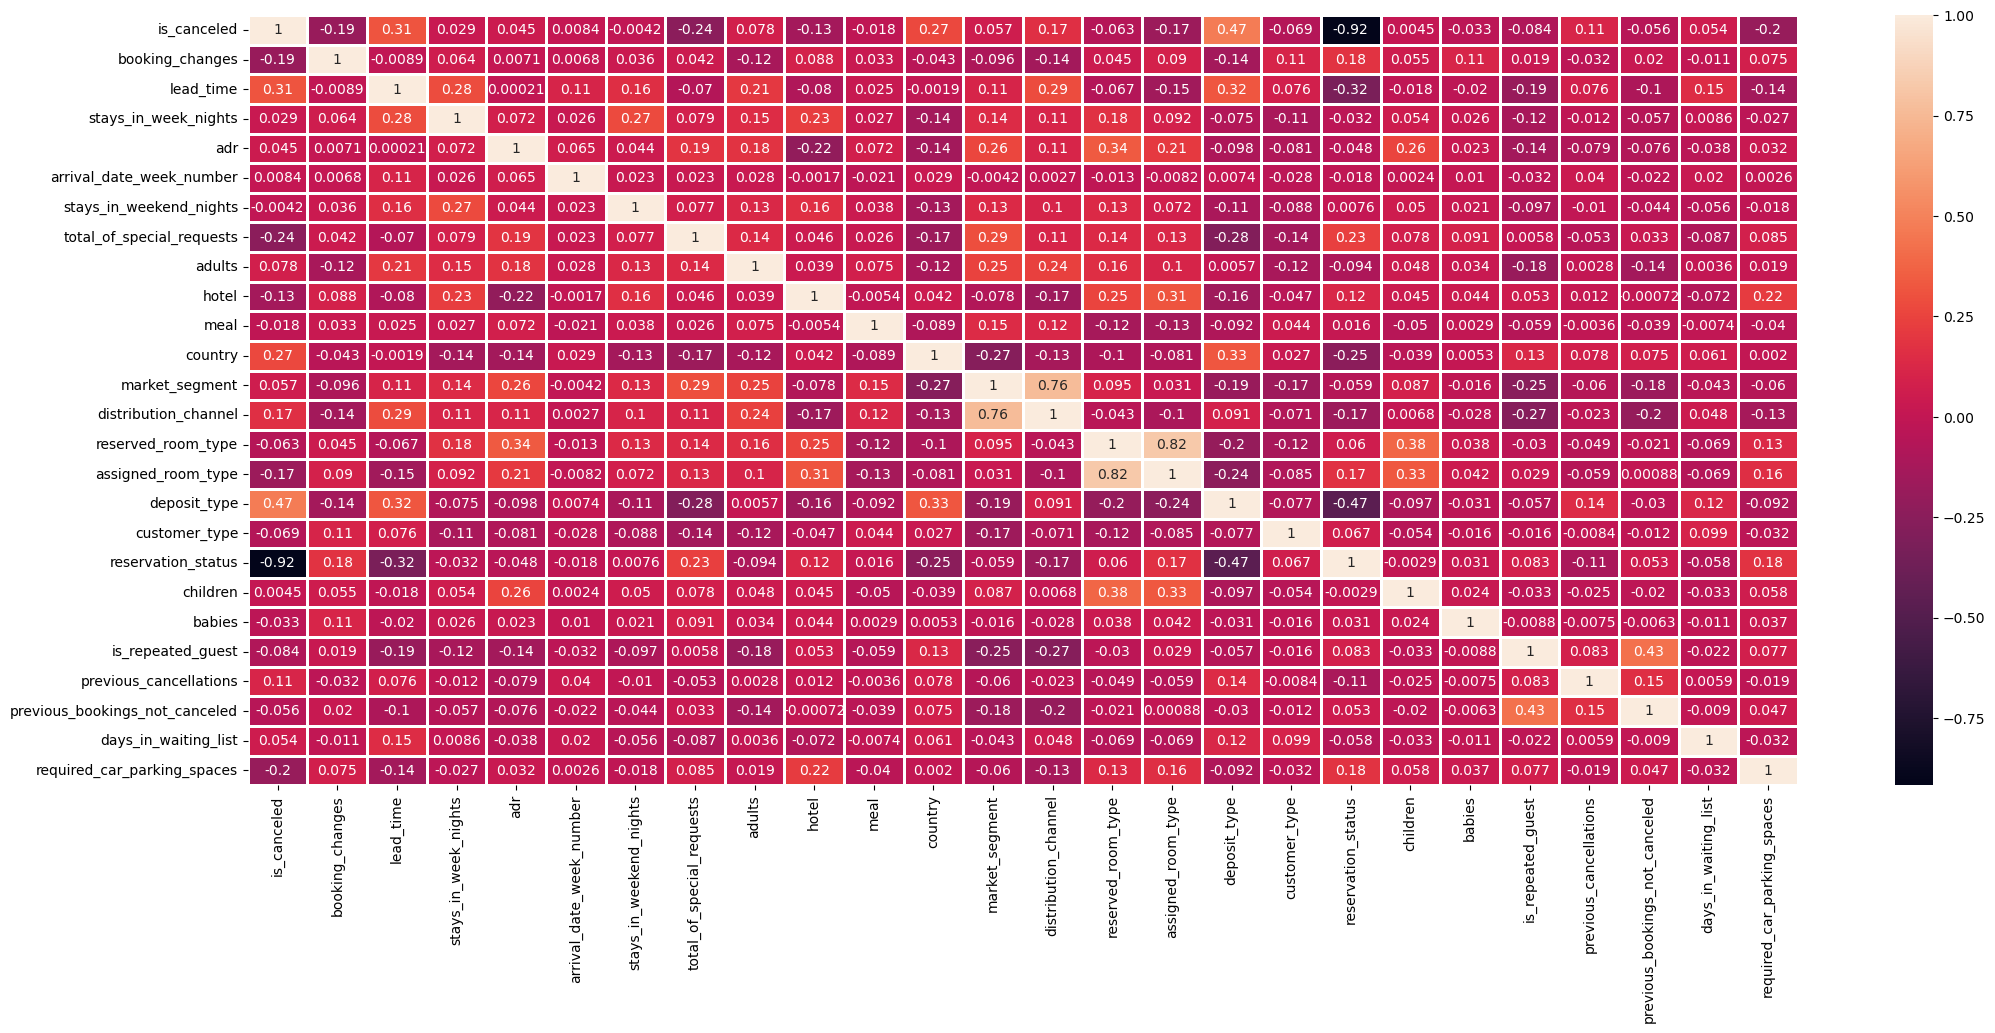

In [204]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize = (25, 10))

corr = transformed_df.corr(method = 'pearson')
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [205]:
correlation = transformed_df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
reservation_status                0.917220
deposit_type                      0.468430
lead_time                         0.312698
country                           0.270894
total_of_special_requests         0.243884
required_car_parking_spaces       0.196941
booking_changes                   0.186603
assigned_room_type                0.174910
distribution_channel              0.165411
hotel                             0.134556
previous_cancellations            0.109902
is_repeated_guest                 0.084146
adults                            0.077827
customer_type                     0.068804
reserved_room_type                0.062586
market_segment                    0.056759
previous_bookings_not_canceled    0.055504
days_in_waiting_list              0.054105
adr                               0.045292
babies                            0.032608
stays_in_week_nights              0.028769
meal                              0.017972
arrival_dat

In [206]:
x_data = transformed_df.drop('is_canceled', axis=1)
x_data.shape

(118732, 25)

In [207]:
# Select the 'is_canceled' column as y_data
y_data = transformed_df['is_canceled']
y_data.shape

(118732,)

In [209]:
# import the train_test_split function from the sklearn.model_selection module
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [210]:
# import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Learning rate set to 0.5
0:	learn: 0.0106191	total: 149ms	remaining: 14.7s
1:	learn: 0.0007967	total: 157ms	remaining: 7.67s
2:	learn: 0.0002565	total: 164ms	remaining: 5.29s
3:	learn: 0.0001582	total: 170ms	remaining: 4.09s
4:	learn: 0.0001582	total: 177ms	remaining: 3.37s
5:	learn: 0.0001582	total: 182ms	remaining: 2.85s
6:	learn: 0.0001583	total: 188ms	remaining: 2.5s
7:	learn: 0.0001583	total: 193ms	remaining: 2.22s
8:	learn: 0.0001582	total: 199ms	remaining: 2.01s
9:	learn: 0.0001582	total: 205ms	remaining: 1.85s
10:	learn: 0.0001582	total: 211ms	remaining: 1.71s
11:	learn: 0.0001582	total: 218ms	remaining: 1.59s
12:	learn: 0.0001582	total: 225ms	remaining: 1.5s
13:	learn: 0.0001582	total: 232ms	remaining: 1.42s
14:	learn: 0.0001582	total: 238ms	remaining: 1.35s
15:	learn: 0.0001582	total: 245ms	remaining: 1.29s
16:	learn: 0.0001582	total: 251ms	remaining: 1.22s
17:	learn: 0.0001582	total: 257ms	remaining: 1.17s
18:	learn: 0.0001582	total: 263ms	remaining: 1.12s
19:	learn: 0.00015

In [211]:
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Cat Boost Classifier is : 1.0
Confusion Matrix : 
[[14822     0]
 [    0  8925]]
Classification Report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14822
         1.0       1.00      1.00      1.00      8925

    accuracy                           1.00     23747
   macro avg       1.00      1.00      1.00     23747
weighted avg       1.00      1.00      1.00     23747



## Feature Selection using SFS (QDA)

In [38]:
# Perform feature selection using Sequential Feature Selector on QDA
qda = QuadraticDiscriminantAnalysis()
sfs = SequentialFeatureSelector(qda, direction='forward', n_features_to_select=7)     # add a new feature as long as 0.01 or more improvement
sfs.fit(x_data, y_data)
x_data_s = sfs.transform(x_data)
sfs.get_feature_names_out()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarr

array(['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'assigned_room_type', 'deposit_type',
       'customer_type'], dtype=object)

In [39]:
# Evaluate the accuracy with and without feature selection
qda.fit(x_data, y_data)
print(f"Score without feature selection: {qda.score(x_data, y_data)}") 
qda.fit(x_data_s, y_data)
print(f"Score with feature selection: {qda.score(x_data_s, y_data)}")

Score without feature selection: 0.628221540949365
Score with feature selection: 0.7486355826567396


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


## Feature Selection using SFS (SVM)

In [40]:
# # Perform feature selection using Sequential Feature Selector on SVM
# svm = SVC()
# sfs = SequentialFeatureSelector(svm, direction='forward', tol=0.01)     # add a new feature as long as 0.01 or more improvement
# sfs.fit(x_data, y_data)
# x_data_s = sfs.transform(x_data)
# sfs.get_feature_names_out()

## Feature Selection using Chi-Square

In [41]:
# Create a function to calculate the chi-square test
# def chi_square_test(df, col1, col2):
#     contingency_table = pd.crosstab(df[col1], df[col2])
#     chi2, p, dof, expected = chi2_contingency(contingency_table)
#     return p

# # Perform the chi-square test for each categorical column with the target column 'is_canceled'
# p_values = {}
# for col in df_cat.columns:
#     p = chi_square_test(df, col, 'is_canceled')
#     p_values[col] = p

# # Reject the null hypothesis if the p-value is less than 0.05
# significant_features = [k for k, v in p_values.items() if v < 0.05]
# significant_features
